<a href="https://colab.research.google.com/github/TNaingHtwe/GraSPP-25S-climatechange/blob/main/notebooks/20250614_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!git clone https://github.com/TNaingHtwe/GraSPP-25S-climatechange.git
%cd GraSPP-25S-climatechange/notebooks

Cloning into 'GraSPP-25S-climatechange'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 382 (delta 55), reused 67 (delta 28), pack-reused 248 (from 1)
Receiving objects: 100% (382/382), 34.63 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/GraSPP-25S-climatechange/notebooks/GraSPP-25S-climatechange/notebooks


In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [33]:
# Load US & Japan manifesto word frequency
manifesto_df = pd.read_csv("../data/processed/manifesto_us_japan_word_freq.csv")
print("Manifesto dataset preview:")
display(manifesto_df.head())
display(manifesto_df ['country'].unique())
display(manifesto_df ['vocab'].unique())
display(manifesto_df ['year'].unique())

# Load NDC word counts
ndc_df = pd.read_csv("../data/processed/ndc_word_counts.csv")
print("NDC word counts preview:")
display(ndc_df.head())

Manifesto dataset preview:


,country,year,vocab,count
0,Japan,2014,ghg,0
1,Japan,2014,greenhouse,0
2,Japan,2014,net-zero,0
3,Japan,2014,carbon,0
4,Japan,2017,ghg,0


array(['Japan', 'United States'], dtype=object)

array(['ghg', 'greenhouse', 'net-zero', 'carbon'], dtype=object)

array([2014, 2017, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992,
       1996, 2000, 2004, 2008, 2012, 2016, 2020])

NDC word counts preview:


,ghg,greenhouse,net-zero,carbon,country
0,7,29,0,21,EU2023
1,1,43,0,36,US2021
2,3,58,0,33,US2024


**China Data From MO san to combine back to manifesto**

In [30]:
# 1. English GHG policy datasets from selenium
df_30 = pd.read_csv("../data/raw/english_policy_GHG_selenium_30.csv")
df_60 = pd.read_csv("../data/raw/english_policy_GHG_selenium_60.csv")
df_90 = pd.read_csv("../data/raw/english_policy_GHG_selenium_90.csv")
df_120 = pd.read_csv("../data/raw/english_policy_GHG_selenium_120.csv")

china_df = pd.concat([df_30, df_60, df_90, df_120], ignore_index=True)

print(f"Combined dataset shape: {china_df.shape}")
display(china_df.head())
china_df.columns


Combined dataset shape: (596, 25)


,title,url,publish_date,has_keyword,matched_keywords,fulltext,page_number,greenhouse gas,ghg,net-zero,...,carbon pricing,low-carbon,clean energy,greenhouse,carbon,environment,emission,environmental,emissions,sustainability
0,China issues guideline to improve market-based...,https://english.www.gov.cn/policies/latestrele...,2025-05-29,True,"greenhouse gas, low-carbon, greenhouse, carbon...","BEIJING, May 29 -- China has recently unveiled...",1,1,0,0,...,0,1,0,1,3,7,2,7,1,0
1,China doubles down on urban upgrades to boost ...,https://english.www.gov.cn/policies/latestrele...,2025-05-15,True,environment,"BEIJING, May 15 -- China is intensifying effor...",1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,China rolls out new regulations on eco-environ...,https://english.www.gov.cn/policies/latestrele...,2025-05-13,True,"carbon neutral, carbon neutrality, carbon, env...","BEIJING, May 12 -- China has rolled out new re...",1,0,0,0,...,0,0,0,0,2,6,0,5,0,0
3,China unveils new regulations on express deliv...,https://english.www.gov.cn/news/202504/18/cont...,2025-04-18,True,"environment, environmental","BEIJING, April 18 -- Chinese Premier Li Qiang ...",1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,China issues new guideline to strengthen price...,https://english.www.gov.cn/policies/latestrele...,2025-04-02,True,environment,"BEIJING, April 2 -- China has unveiled a guide...",2,0,0,0,...,0,0,0,0,0,2,0,0,0,0


Index(['title', 'url', 'publish_date', 'has_keyword', 'matched_keywords',
       'fulltext', 'page_number', 'greenhouse gas', 'ghg', 'net-zero',
       'carbon neutral', 'carbon neutrality', 'carbon emissions',
       'climate change', 'carbon trading', 'carbon pricing', 'low-carbon',
       'clean energy', 'greenhouse', 'carbon', 'environment', 'emission',
       'environmental', 'emissions', 'sustainability'],
      dtype='object')

**Merging China Separate Data Into One**

In [64]:
# STEP 1: Define which columns are keywords
keyword_cols = ['ghg', 'net-zero', 'carbon', 'greenhouse']

# STEP 2: Keep relevant metadata + keywords only
china_subset = china_df[['publish_date'] + keyword_cols].copy()

# STEP 3: Add country column
china_subset['country'] = 'China'

# STEP 4: Convert date to year (assumes format is YYYY-MM-DD or similar)
china_subset['year'] = pd.to_datetime(china_subset['publish_date'], errors='coerce').dt.year

# STEP 5: Reshape to long format (melt)
china_combined_df = china_subset.melt(
    id_vars=['country', 'year'],
    value_vars=keyword_cols,
    var_name='vocab',
    value_name='count'
)

# Optional: Drop rows with missing year or zero count
china_combined_df = china_combined_df.dropna(subset=['year'])
china_combined_df['year'] = china_combined_df['year'].astype(int)

# Group and aggregate to remove duplicates
china_combined_df = (
    china_combined_df
    .groupby(['country', 'year', 'vocab'], as_index=False)
    .agg({'count': 'sum'})
)



# Final
display(china_combined_df)


display(china_combined_df ['vocab'].unique())
display(china_combined_df ['year'].unique())

,country,year,vocab,count
0,China,2016,carbon,18
1,China,2016,ghg,0
2,China,2016,greenhouse,1
3,China,2016,net-zero,0
4,China,2017,carbon,4
5,China,2017,ghg,0
6,China,2017,greenhouse,0
7,China,2017,net-zero,0
8,China,2018,carbon,0
9,China,2018,ghg,0


array(['carbon', 'ghg', 'greenhouse', 'net-zero'], dtype=object)

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

**Usable Years Common in Both Datasets**

In [73]:
# Unique years in each dataset
years_china = set(china_combined_df['year'].unique())
years_manifesto = set(manifesto_df['year'].unique())

# Find the intersection
common_years = sorted(list(years_china & years_manifesto))
print("Overlapping years:", common_years)


Overlapping years: [np.int64(2016), np.int64(2017), np.int64(2020)]


In [74]:
# Filter both DataFrames
china_filtered = china_combined_df[china_combined_df['year'].isin(common_years)]
manifesto_filtered = manifesto_df[manifesto_df['year'].isin(common_years)]

word_count_year_filtered_df= pd.concat([manifesto_filtered, china_filtered], ignore_index=True)
print(word_count_year_filtered_df['country'].unique())
print(word_count_year_filtered_df['year'].unique())
word_count_year_filtered_df

['Japan' 'United States' 'China']
[2017 2016 2020]


,country,year,vocab,count
0,Japan,2017,ghg,0
1,Japan,2017,greenhouse,0
2,Japan,2017,net-zero,0
3,Japan,2017,carbon,0
4,United States,2016,ghg,0
5,United States,2016,greenhouse,6
6,United States,2016,net-zero,0
7,United States,2016,carbon,10
8,United States,2020,ghg,0
9,United States,2020,greenhouse,5


**Japan Text Sanity Check**

In [71]:
# Filter only Japan
japan_manifesto = manifesto_df[manifesto_df['country'] == 'Japan']

# Preview
display(japan_manifesto.head())

# Check unique years
print("Years with Japan data:", japan_manifesto['year'].unique())

# Check if years 2016 and 2020 are present
print(japan_manifesto[japan_manifesto['year'].isin([2016, 2020])])

# Optional: Sum counts by year and vocab to confirm all are zero
summary = japan_manifesto.groupby(['year', 'vocab'])['count'].sum().unstack(fill_value=0)
display(summary)

,country,year,vocab,count
0,Japan,2014,ghg,0
1,Japan,2014,greenhouse,0
2,Japan,2014,net-zero,0
3,Japan,2014,carbon,0
4,Japan,2017,ghg,0


Years with Japan data: [2014 2017]
Empty DataFrame
Columns: [country, year, vocab, count]
Index: []


vocab,carbon,ghg,greenhouse,net-zero
year,,,,
2014,0,0,0,0
2017,0,0,0,0


In [69]:
#Full versions
word_count_year_all_df = pd.concat([manifesto_df, china_combined_df], ignore_index=True)

# Preview
print("Countries:", word_count_year_all_df['country'].unique())
print("Years:", sorted(word_count_year_all_df['year'].unique()))
display(word_count_year_all_df.head())

Countries: ['Japan' 'United States' 'China']
Years: [np.int64(1960), np.int64(1964), np.int64(1968), np.int64(1972), np.int64(1976), np.int64(1980), np.int64(1984), np.int64(1988), np.int64(1992), np.int64(1996), np.int64(2000), np.int64(2004), np.int64(2008), np.int64(2012), np.int64(2014), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


,country,year,vocab,count
0,Japan,2014,ghg,0
1,Japan,2014,greenhouse,0
2,Japan,2014,net-zero,0
3,Japan,2014,carbon,0
4,Japan,2017,ghg,0


In [ ]:
# Filtered version (overlapping years only)
#word_count_year_filtered_df.to_csv("../data/processed/word_count_filtered.csv", index=False)

# Unfiltered full version
#word_count_year_all_df.to_csv("../data/processed/word_count_full.csv", index=False)


**Now, GHG Data to clean**

In [75]:
# Load GHG emission data from one level up in data/processed
ghg_df = pd.read_csv("../data/processed/edgar_ghg_emission_processed.csv")
display(ghg_df.head())
ghg_df['Country'].unique()

,Unnamed: 0,Country,Year,Emission (MtCO2eq/yr)
0,0,GLOBAL TOTAL,2014-01-01,48930.176837
1,1,GLOBAL TOTAL,2015-01-01,48808.767176
2,2,GLOBAL TOTAL,2016-01-01,49058.441256
3,3,GLOBAL TOTAL,2017-01-01,49878.733809
4,4,GLOBAL TOTAL,2018-01-01,51026.627449


array(['GLOBAL TOTAL', 'China', 'United States', 'India', 'EU27',
       'Russia', 'Brazil', 'Indonesia', 'Japan', 'Iran', 'Saudi Arabia',
       'Canada'], dtype=object)

In [83]:
# Extract year from datetime
ghg_df['year'] = pd.to_datetime(ghg_df['Year']).dt.year

# Keep only needed columns
ghg_df_clean = ghg_df[['Country', 'year', 'Emission (MtCO2eq/yr)']].copy()

# Rename for consistency
ghg_df_clean.columns = ['country', 'year', 'ghg_emission']

# Match the countries
target_countries = ['China', 'Japan', 'United States']

# Filter GHG emissions
ghg_filtered_df = ghg_df_clean[ghg_df_clean['country'].isin(target_countries)]

japan_years = [2016, 2017, 2020]

# Apply conditional filtering
ghg_filtered_common_years = ghg_filtered_df[
    ((ghg_filtered_df['country'] == 'Japan') & ghg_filtered_df['year'].isin(japan_years)) |
    ((ghg_filtered_df['country'].isin(['China', 'United States'])) & ghg_filtered_df['year'].isin(common_years))
]
ghg_filtered_common_years

,country,year,ghg_emission
12,China,2016,13105.715333
13,China,2017,13362.318184
16,China,2020,14497.898717
22,United States,2016,6206.284817
23,United States,2017,6151.772377
26,United States,2020,5671.604437
82,Japan,2016,1331.349824
83,Japan,2017,1316.811289
86,Japan,2020,1168.753373


**Combine back to word count data**

In [86]:
merged_filtered_df = pd.merge(
    word_count_year_filtered_df,
    ghg_filtered_common_years,
    on=['country', 'year'],
    how='left'  # ensures word count stays even if some emission values are missing
)

print(merged_filtered_df.shape)
display(merged_filtered_df)

#Any missing emissions?
print(merged_filtered_df['ghg_emission'].isna().sum())


(24, 5)


,country,year,vocab,count,ghg_emission
0,Japan,2017,ghg,0,1316.811289
1,Japan,2017,greenhouse,0,1316.811289
2,Japan,2017,net-zero,0,1316.811289
3,Japan,2017,carbon,0,1316.811289
4,United States,2016,ghg,0,6206.284817
5,United States,2016,greenhouse,6,6206.284817
6,United States,2016,net-zero,0,6206.284817
7,United States,2016,carbon,10,6206.284817
8,United States,2020,ghg,0,5671.604437
9,United States,2020,greenhouse,5,5671.604437


0


In [98]:
# Sum all keyword counts by country and year
agg_word_df = word_count_year_filtered_df.groupby(['country', 'year'])['count'].sum().reset_index(name='total_mentions')
# Merge with GHG emissions
merged_df = pd.merge(agg_word_df, merged_filtered_df, on=['country', 'year'], how='inner')
merged_df

,country,year,total_mentions,vocab,count,ghg_emission
0,China,2016,19,carbon,18,13105.715333
1,China,2016,19,ghg,0,13105.715333
2,China,2016,19,greenhouse,1,13105.715333
3,China,2016,19,net-zero,0,13105.715333
4,China,2017,4,carbon,4,13362.318184
5,China,2017,4,ghg,0,13362.318184
6,China,2017,4,greenhouse,0,13362.318184
7,China,2017,4,net-zero,0,13362.318184
8,China,2020,3,carbon,3,14497.898717
9,China,2020,3,ghg,0,14497.898717


**GHG emission on 3 overlapping yrs**

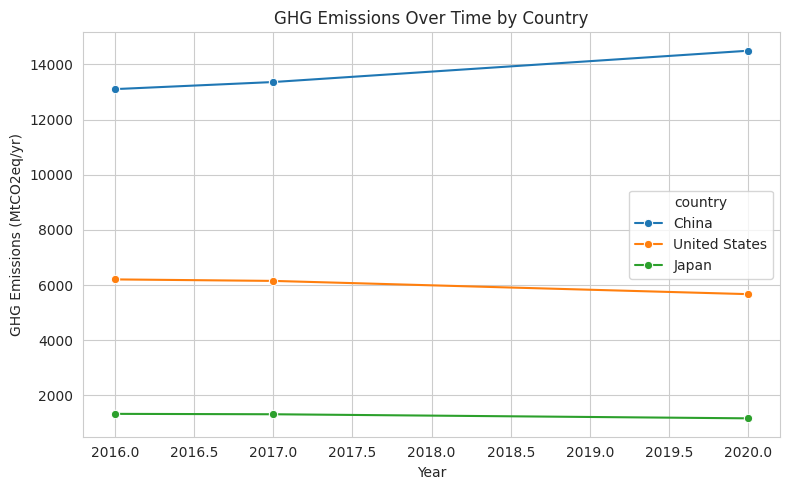

In [99]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=ghg_filtered_common_years, x='year', y='ghg_emission', hue='country', marker='o')
plt.title('GHG Emissions Over Time by Country')
plt.ylabel('GHG Emissions (MtCO2eq/yr)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

**Word Counts Mentioned**

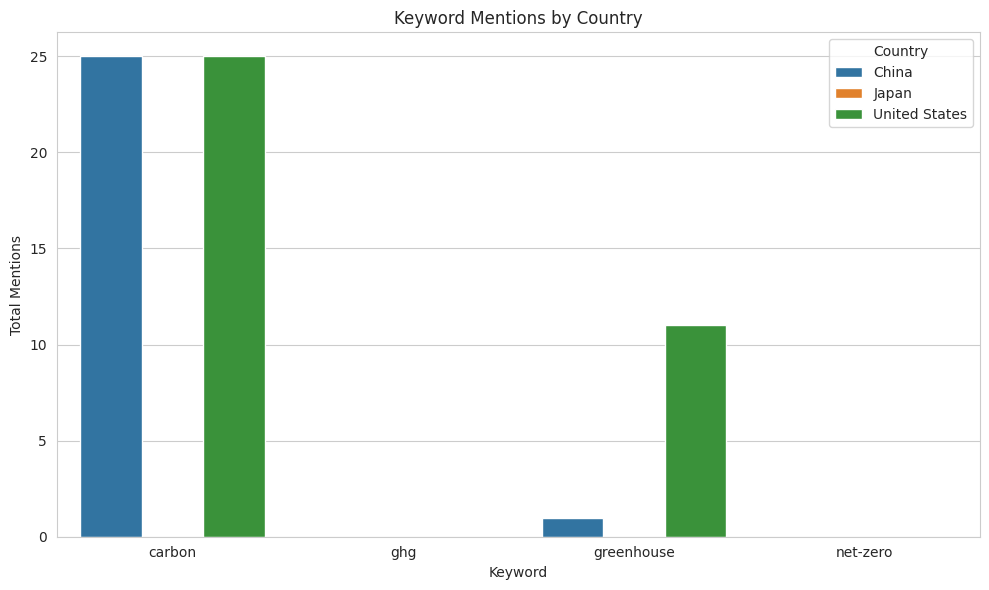

In [101]:
# Sum counts by country and vocabulary
word_count_summary = word_count_year_filtered_df.groupby(['country', 'vocab'])['count'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=word_count_summary, x='vocab', y='count', hue='country')

plt.title("Keyword Mentions by Country")
plt.xlabel("Keyword")
plt.ylabel("Total Mentions")
plt.legend(title='Country')
plt.tight_layout()
plt.show()

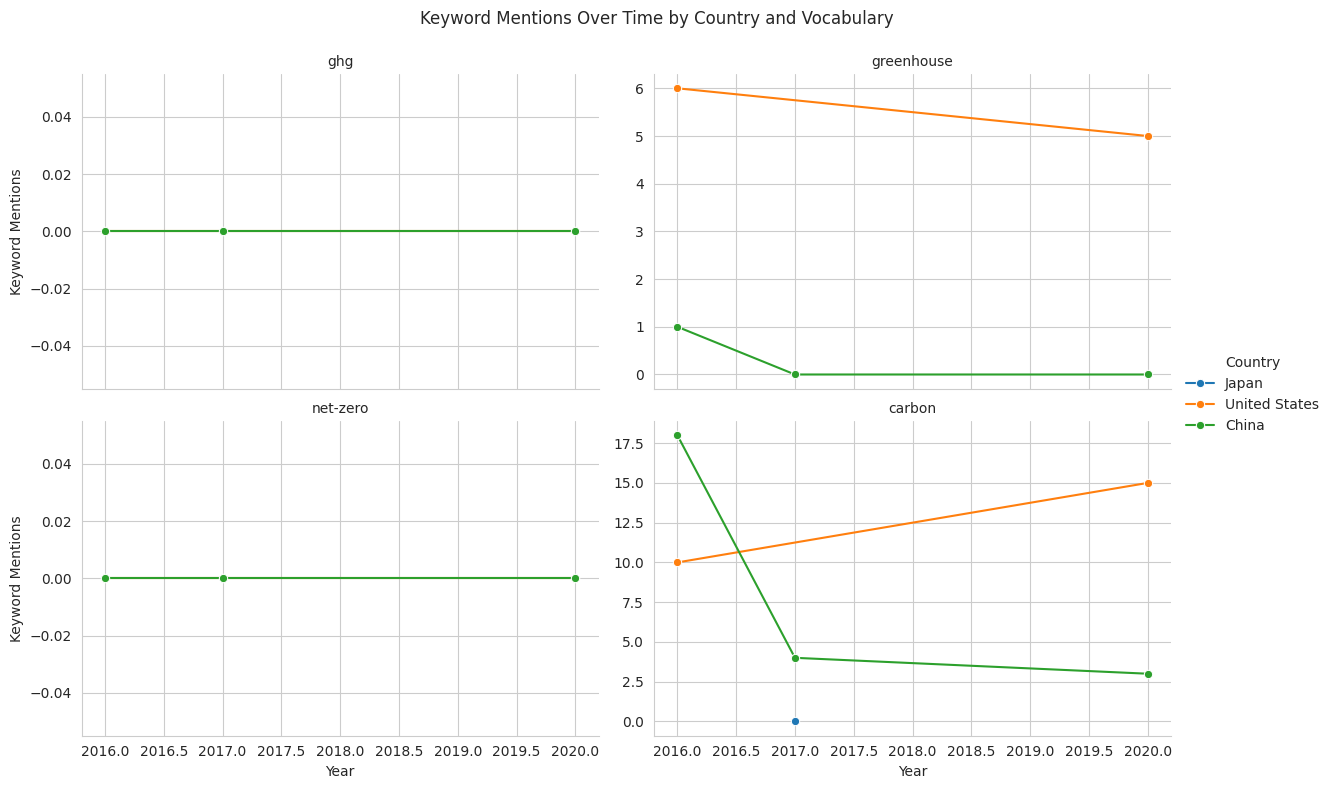

In [90]:
# Set theme
sns.set_style("whitegrid")

# Create the FacetGrid
g = sns.FacetGrid(
    word_count_year_filtered_df,
    col="vocab",
    hue="country",
    col_wrap=2,          # Adjust columns per row
    height=4,
    aspect=1.5,
    sharey=False         # Allow different y-axis scales per facet
)

# Add lineplots to each facet
g.map(sns.lineplot, "year", "count", marker="o")

# Customize
g.add_legend(title="Country")
g.set_axis_labels("Year", "Keyword Mentions")
g.set_titles(col_template="{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Keyword Mentions Over Time by Country and Vocabulary")

plt.show()

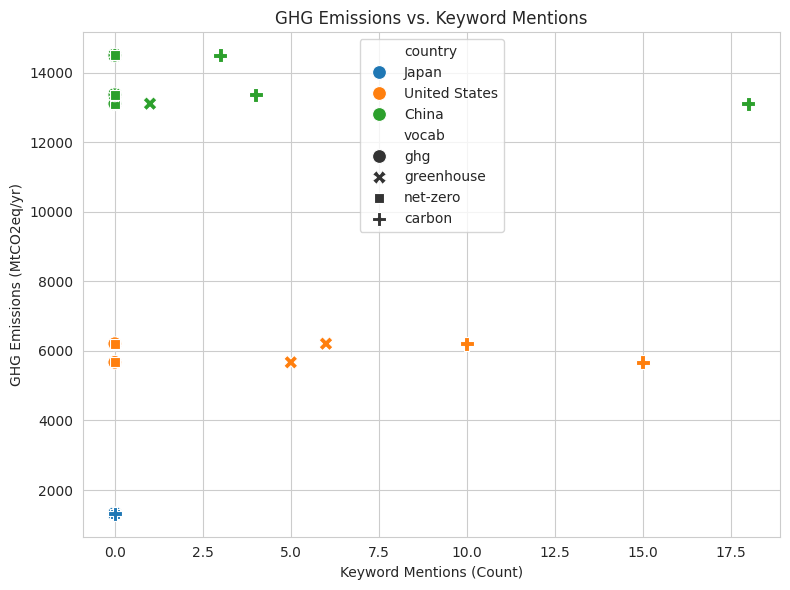

In [91]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_filtered_df,
    x="count",
    y="ghg_emission",
    hue="country",
    style="vocab",
    s=100  # size of the points
)

plt.title("GHG Emissions vs. Keyword Mentions")
plt.xlabel("Keyword Mentions (Count)")
plt.ylabel("GHG Emissions (MtCO2eq/yr)")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

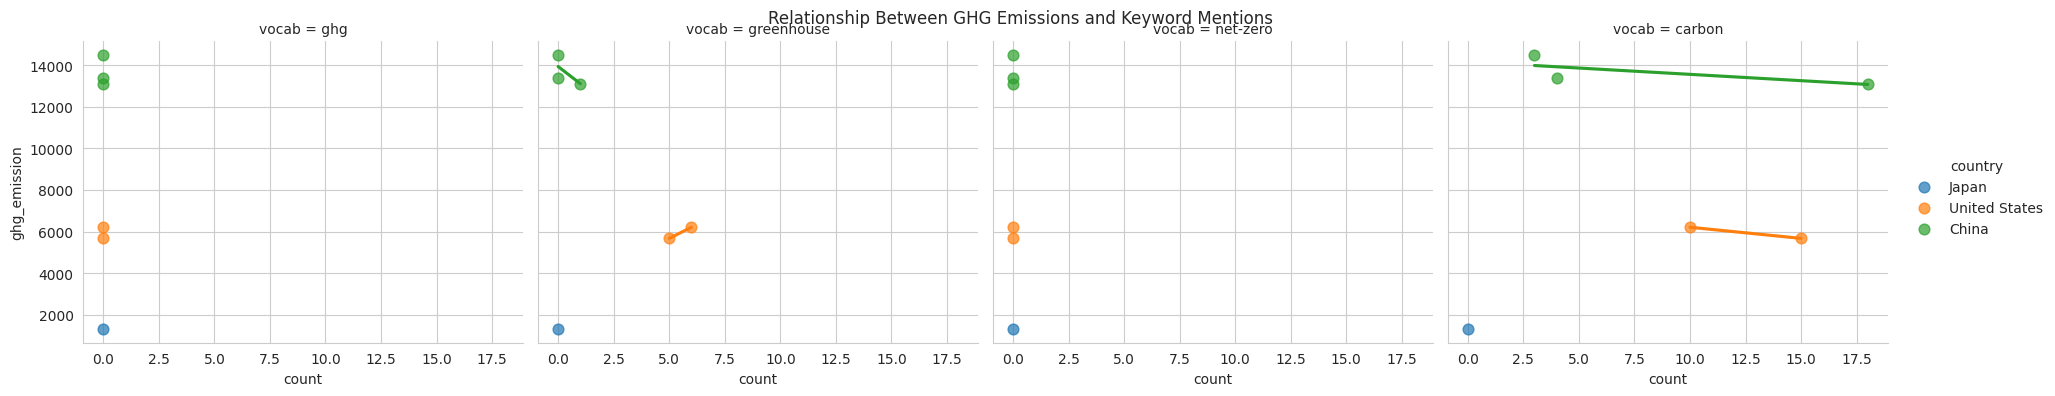

In [92]:
plt.figure(figsize=(8, 6))
sns.lmplot(
    data=merged_filtered_df,
    x="count",
    y="ghg_emission",
    hue="country",
    col="vocab",     # optional facet by keyword
    scatter_kws={"s": 60, "alpha": 0.7},
    height=4,
    aspect=1.2,
    markers='o',
    ci=None
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Relationship Between GHG Emissions and Keyword Mentions")
plt.show()

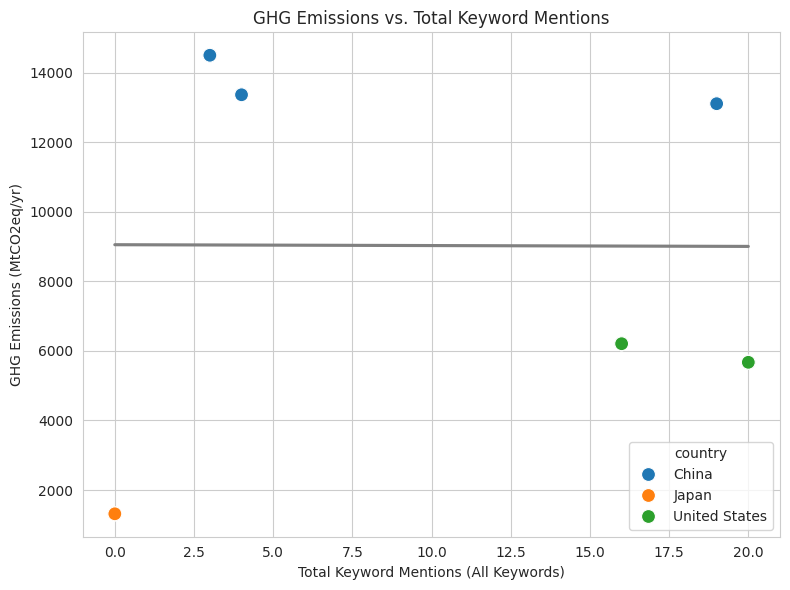

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='total_mentions', y='ghg_emission', hue='country', s=100)
sns.regplot(data=merged_df, x='total_mentions', y='ghg_emission', scatter=False, ci=None, color='gray')

plt.title("GHG Emissions vs. Total Keyword Mentions")
plt.xlabel("Total Keyword Mentions (All Keywords)")
plt.ylabel("GHG Emissions (MtCO2eq/yr)")
plt.grid(True)
plt.tight_layout()
plt.show()


**SIMPLE REGRESSION**

In [103]:
  # Prepare data
X = merged_df['total_mentions']
y = merged_df['ghg_emission']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Display summary
print(model.summary())

correlation = merged_df[['total_mentions', 'ghg_emission']].corr()
print(correlation)


                            OLS Regression Results                            
Dep. Variable:           ghg_emission   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                 0.0003623
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.985
Time:                        07:11:04   Log-Likelihood:                -237.98
No. Observations:                  24   AIC:                             480.0
Df Residuals:                      22   BIC:                             482.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9051.8931   1683.092      5.